In [95]:
import torch
import cv2
import os
import json
import csv
import math
from math import exp, sqrt, pi, floor
import seaborn as sns
import random
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
%matplotlib inline

# Generating heatmaps

In [96]:
def _gaussian(
        size=3, sigma=0.25, amplitude=1, normalize=False, width=None,
        height=None, sigma_horz=None, sigma_vert=None, mean_horz=0.5,
        mean_vert=0.5):
    # handle some defaults
    if width is None:
        width = size
    if height is None:
        height = size
    if sigma_horz is None:
        sigma_horz = sigma
    if sigma_vert is None:
        sigma_vert = sigma
    center_x = mean_horz * width + 0.5
    center_y = mean_vert * height + 0.5
    gauss = np.empty((height, width), dtype=np.float32)
    # generate kernel
    for i in range(height):
        for j in range(width):
            gauss[i][j] = amplitude * math.exp(-(math.pow((j + 1 - center_x) / (
                sigma_horz * width), 2) / 2.0 + math.pow((i + 1 - center_y) / (sigma_vert * height), 2) / 2.0))
    if normalize:
        gauss = gauss / np.sum(gauss)
    return gauss

In [97]:
def hm_from_lm(image, point, sigma):
        ul = [math.floor(point[0] - 3 * sigma), math.floor(point[1] - 3 * sigma)]
        br = [math.floor(point[0] + 3 * sigma), math.floor(point[1] + 3 * sigma)]
        if (ul[0] > image.shape[1] or ul[1] >
                image.shape[0] or br[0] < 1 or br[1] < 1):
            return image
        size = 6 * sigma + 1
        g = _gaussian(size)
        g_x = [int(max(1, -ul[0])), int(min(br[0], image.shape[1])) -
               int(max(1, ul[0])) + int(max(1, -ul[0]))]
        g_y = [int(max(1, -ul[1])), int(min(br[1], image.shape[0])) -
               int(max(1, ul[1])) + int(max(1, -ul[1]))]
        img_x = [int(max(1, ul[0])), int(min(br[0], image.shape[1]))]
        img_y = [int(max(1, ul[1])), int(min(br[1], image.shape[0]))]
        assert (g_x[0] > 0 and g_y[1] > 0)
        image[img_y[0] - 1:img_y[1], img_x[0] - 1:img_x[1]
              ] = image[img_y[0] - 1:img_y[1], img_x[0] - 1:img_x[1]] + g[g_y[0] - 1:g_y[1], g_x[0] - 1:g_x[1]]
        image[image > 1] = 1
        return image

In [98]:
def get_img_center_and_radius(img_name):
    eye_centers = {}
    with open('crowdpupil/results.csv', newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=';')
        for row in spamreader:
            eye_centers[row[0]] = (int(row[1]), int(row[2]))
            
    with open('crowdpupil/eye_radius.json', 'r') as fp:
        eye_radius = json.load(fp)
            
    return (eye_centers[img_name], sum(eye_radius.values())/len(eye_radius))

In [99]:
eye_images = os.listdir('./crowdpupil/images')

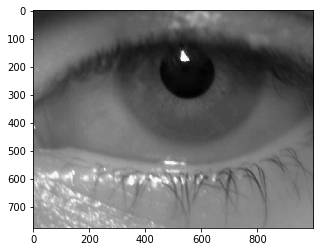

In [104]:
img_name = random.choice(eye_images)
img = cv2.imread('./crowdpupil/images/' + img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')

In [180]:
def generate_heatmap_from_img (img_name):
    img = cv2.imread('crowdpupil/images/' + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    center, radius = get_img_center_and_radius(img_name)

    m1 = center
    s1 = np.eye(2) * radius ** 1.5
    k1 = multivariate_normal(mean=m1, cov=s1)

    # create a grid of (x,y) coordinates at which to evaluate the kernels
    x = np.linspace(0, img.shape[1], img.shape[1])
    y = np.linspace(0, img.shape[0], img.shape[0])
    xx, yy = np.meshgrid(x,y)

    # evaluate kernels at grid points
    xxyy = np.c_[xx.ravel(), yy.ravel()]
    zz = k1.pdf(xxyy)

    # reshape and plot image
    heatmap = zz.reshape(img.shape)
    cv2.imwrite('crowdpupil/heatmaps/h_' + img_name, heatmap * 255 / np.amax(heatmap))

In [181]:
os.makedirs('crowdpupil/heatmaps', exist_ok=True)
for index, img in enumerate(eye_images):
    generate_heatmap_from_img(img)
    if index % 50 == 0:
        print (f'Done {index}/{len(eye_images)}')

Done 0/792
Done 50/792
Done 100/792
Done 150/792
Done 200/792
Done 250/792
Done 300/792
Done 350/792
Done 400/792
Done 450/792
Done 500/792
Done 550/792
Done 600/792
Done 650/792
Done 700/792
Done 750/792


In [182]:
def lm_from_hm(hm, center=None, scale=None):
    max, idx = torch.max(
        hm.contiguous().view(hm.size(0), hm.size(1), hm.size(2) * hm.size(3)), 2)
    idx += 1
    preds = idx.view(idx.size(0), idx.size(1), 1).repeat(1, 1, 2).float()
    preds[..., 0].apply_(lambda x: (x - 1) % hm.size(3) + 1)
    preds[..., 1].add_(-1).div_(hm.size(2)).floor_().add_(1)

    for i in range(preds.size(0)):
        for j in range(preds.size(1)):
            hm_ = hm[i, j, :]
            pX, pY = int(preds[i, j, 0]) - 1, int(preds[i, j, 1]) - 1
            if pX > 0 and pX < 63 and pY > 0 and pY < 63:
                diff = torch.FloatTensor(
                    [hm_[pY, pX + 1] - hm_[pY, pX - 1],
                        hm_[pY + 1, pX] - hm_[pY - 1, pX]])
                preds[i, j].add_(diff.sign_().mul_(.25))

    preds.add_(-.5)

    preds_orig = torch.zeros(preds.size())
    if center is not None and scale is not None:
        for i in range(hm.size(0)):
            for j in range(hm.size(1)):
                preds_orig[i, j] = transform(
                    preds[i, j], center, scale, hm.size(2), True)

    return preds, preds_orig

In [184]:
lm_from_hm(heatmap)

AttributeError: 'numpy.ndarray' object has no attribute 'contiguous'